<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 01_InitialDataPreparation

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load Data)    
    
    
+ [Prepare Data for Modelling](#Prepare-Data-for-Modelling)
    + [Initial Descriptive Analysis](Initial-Descriptive-Analysis)


# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [2]:
from __future__ import division, print_function
from collections import OrderedDict
import re
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import StratifiedShuffleSplit
import triangle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 16, 3

np.random.seed(0)

### Local Functions

### Load Data

**NOTE:** Assume that the statements in `data/docs/sql_readme` have been followed and we have a basic database in `data/`

In [42]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival', con=cnx
                 ,index_col='diskid', parse_dates=['startdate','enddate'])

In [43]:
print(df.shape)
df.head()

(49112, 7)


,model,capacitybytes,startdate,enddate,nrecords,nhoursinserviceduringstudy,failed
diskid,,,,,,,
13H2B97AS,TOSHIBA DT01ACA300,3000592982016,2013-10-15,2014-10-03,354,8467,0
13H3012AS,TOSHIBA DT01ACA300,3000592982016,2013-10-15,2014-09-08,329,7866,0
13H32WEAS,TOSHIBA DT01ACA300,3000592982016,2013-04-26,2014-12-31,558,14733,0
13H6A0DGS,TOSHIBA DT01ACA300,3000592982016,2013-04-20,2014-09-02,444,11993,0
13H6A21GS,TOSHIBA DT01ACA300,3000592982016,2013-05-22,2014-12-31,532,14094,0


In [44]:
df.describe()

,capacitybytes,nrecords,nhoursinserviceduringstudy,failed
count,4.911200e+04,49112.000000,49112.000000,49112.000000
mean,2.989858e+13,359.869584,9381.556666,0.059985
std,3.861436e+15,193.732895,5137.660993,0.239341
min,8.002636e+10,1.000000,-253.000000,0.000000
25%,3.000593e+12,183.000000,4682.000000,0.000000
50%,4.000787e+12,381.000000,9864.000000,0.000000
75%,4.000787e+12,571.000000,15108.000000,0.000000
max,6.003326e+17,630.000000,17191.000000,3.000000


**Note:** totalhoursinservice should be numeric and appear in `.describe()`: assume it contains characters need to clean

---

# Prepare Data for Modelling

Initial Corrections and Thresholds

## 1. Correction: some disks with have >1 row with failure

In [45]:
df.groupby('failed').size()

failed
0         46182
1          2920
2             4
3             6
dtype: int64

##### Quick look in DB

In [46]:
df.loc[df['failed'] >=2]

,model,capacitybytes,startdate,enddate,nrecords,nhoursinserviceduringstudy,failed
diskid,,,,,,,
S1F013DY,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,8497,3
S1F018ZS,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,8495,3
S1F01QSC,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,8498,3
S1F02N2X,ST3000DM001,3000592982016,2013-04-10,2014-10-01,295,8497,3
S1F02PL9,ST3000DM001,3000592982016,2013-04-10,2014-07-17,243,7128,3
S1F02ZVX,ST3000DM001,3000592982016,2013-04-10,2014-09-08,295,8380,3
WD-WCAWZ0257539,WDC WD30EZRS,3000592982016,2013-04-10,2014-01-03,212,6387,2
WD-WCAWZ0815286,WDC WD30EZRX,3000592982016,2013-04-10,2014-01-03,212,6387,2
WD-WCAWZ1005658,WDC WD30EZRX,3000592982016,2013-04-10,2014-01-03,212,6388,2


Anything we can learn from them?

In [47]:
diskids = '", "'.join(df.loc[df['failed'] >=2].index.values)
diskids = '"' + diskids + '"'
qdf = pd.read_sql("select * from drive_stats where serial_number in ({})".format(diskids), con=cnx)
qdf.shape

(2570, 85)

In [48]:
print(qdf.loc[qdf['failure'] >0].sort(['serial_number','date']).shape)
qdf.loc[qdf['failure'] >0].sort(['serial_number','date']).head()

(26, 85)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
1458,2013-05-06,S1F013DY,ST3000DM001,3000592982016,1,,165894456,,,,...,,,,,,,,,,
2120,2013-07-18,S1F013DY,ST3000DM001,3000592982016,1,,191156408,,,,...,,,,,,,,,,
1209,2014-10-01,S1F013DY,ST3000DM001,3000592982016,1,117,137089768,,,92,...,,,,,,,,,,
1452,2013-05-06,S1F018ZS,ST3000DM001,3000592982016,1,,25451944,,,,...,,,,,,,,,,
2116,2013-07-18,S1F018ZS,ST3000DM001,3000592982016,1,,14022976,,,,...,,,,,,,,,,


**Observe:** No clear pattern for these repeatedly failing drives

##### Decision: remove the disks with >1 row of failure, they're complicating the picture

In [49]:
df = df.loc[df['failed'] <=1]
df.shape

(49102, 7)

## 1b. Remove: some rows have negative uptime

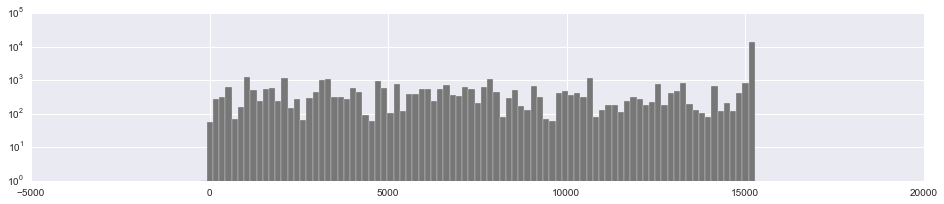

In [50]:
ax = df['nhoursinserviceduringstudy'].hist(bins=100, log=True)

In [51]:
df.loc[df['nhoursinserviceduringstudy'] <0]

,model,capacitybytes,startdate,enddate,nrecords,nhoursinserviceduringstudy,failed
diskid,,,,,,,
PL1331LAGS1E5H,HGST HMS5C4040ALE640,4000787030016,2014-08-13,2014-12-02,72,-11,1
Z300PB0A,ST4000DM000,4000787030016,2013-11-06,2014-03-17,132,-253,1
Z3016S30,ST4000DM000,4000787030016,2014-03-08,2014-11-18,255,-33,1
Z3016S57,ST4000DM000,4000787030016,2014-03-08,2014-11-18,255,-33,1


##### Decision: remove offending rows

In [52]:
df = df.loc[df['nhoursinserviceduringstudy'] >= 0]
df.shape

(49098, 7)

## 1c. Correction: some disks have a mismatched start-end periods vs nrecords

In [53]:
np.sum((df['enddate'] - df['startdate']).astype('timedelta64[D]') == df['nrecords']) / df.shape[0]

0.24719947859383273

**Warning: only 25% of disks have a match**

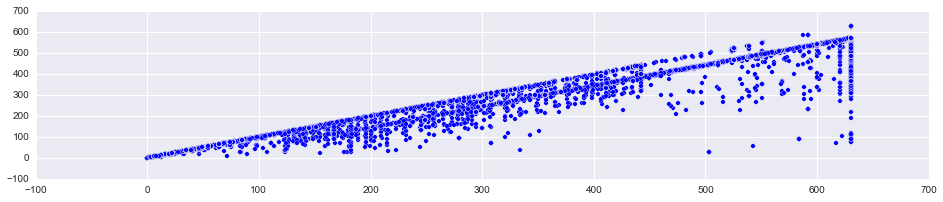

In [54]:
ax = plt.scatter(x=(df['enddate'] - df['startdate']).astype('timedelta64[D]'), y=df['nrecords'])

In [55]:
((df['enddate'] - df['startdate']).astype('timedelta64[D]') - df['nrecords']).value_counts().order(ascending=False)

 0     12137
 56     8351
-1      3932
 55     3475
 59     3171
 58     2866
 60     2594
 57     1638
 3      1049
 1       951
 2       886
 4       697
 13      505
 12      371
 14      370
...
332    1
292    1
337    1
350    1
409    1
440    1
488    1
509    1
534    1
349    1
289    1
288    1
286    1
239    1
147    1
Length: 277, dtype: int64

**Solution:** We'll use a computed time startdate to enddate for duration

In [56]:
df['ndaysduration'] = (df['enddate'] - df['startdate']).astype('timedelta64[D]')

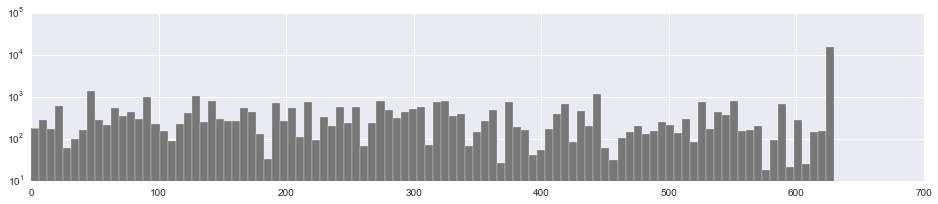

In [57]:
ax = df['ndaysduration'].hist(bins=100,log=True)

## 2. Reduction: ignore drives that are too small or too big

In [58]:
df.groupby('capacitybytes').size()

capacitybytes
80026361856             131
160041885696            252
250000000000              1
250059350016            127
320072933376            146
500107862016            392
1000204886016           728
1125281560064             1
1194001036800             1
1500301910016          3106
2000398934016          5259
3000592982016         12384
4000787030016         26250
6001175126016           317
107349320986927104        1
600332565813390450        2
dtype: int64

##### Decision: remove drives below 1.5TB and above 6TB, and remove single instance 1TB drives

In [59]:
df = df.loc[(df['capacitybytes'] < 10e12) & (df['capacitybytes'] > 1500e9)]
df.groupby('capacitybytes').size()

capacitybytes
1500301910016     3106
2000398934016     5259
3000592982016    12384
4000787030016    26250
6001175126016      317
dtype: int64

## 3. Cleaning: correctly identify manufacturer

In [60]:
df['manufacturer'] = df['model'].apply(lambda x: x.split()[0])
df['model'] = df['model'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else x)
df.groupby(['manufacturer','model']).size()

manufacturer  model          
HGST          HDS5C4040ALE630        6
              HDS724040ALE640       42
              HMS5C4040ALE640     7167
              HMS5C4040BLE640     3115
Hitachi       HDS5C3030ALA630     4651
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2719
              HDS722020ALA330     4774
              HDS723020BLA642       11
              HDS723030ALA640     1046
              HDS723030BLE640       10
              HDS724040ALE640        1
SAMSUNG       HD154UI                4
ST1500DL001   ST1500DL001            2
ST1500DL003   ST1500DL003          116
ST1500DM003   ST1500DM003            5
ST2000DL001   ST2000DL001           12
ST2000DL003   ST2000DL003           16
ST2000DM001   ST2000DM001            8
ST2000VN000   ST2000VN000            5
ST3000DM001   ST3000DM001         4697
ST31500341AS  ST31500341AS         787
ST31500541AS  ST31500541AS        2188
ST32000542AS  ST32000542AS         385
ST320005XXXX  ST320005XXXX        

##### Correct for missing Seagate

In [61]:
df['manufacturer'] = df['manufacturer'].apply(lambda x: 'SEAGATE' if x[:2] == 'ST' else x)

##### Merge HGST and Hitachi

In [62]:
df.loc[df['manufacturer'] == 'Hitachi','manufacturer'] = 'HGST'

## 4. Cleaning: make capacities human readable

In [63]:
df['capacity'] = df['capacitybytes'].apply(lambda x: '{}TB'.format(round(x / 1e12,2)))
df.groupby(['capacity']).size()

capacity
1.5TB        3106
2.0TB        5259
3.0TB       12384
4.0TB       26250
6.0TB         317
dtype: int64

## 5. Checking: Are manufacturer-capacities well-represented?

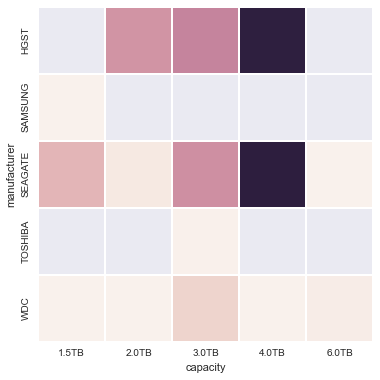

In [64]:
gp = df.groupby(['manufacturer','capacity']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

##### Decision: Exclude Samsung and Toshiba

In [65]:
df = df.loc[df['manufacturer'].isin(['HGST','SEAGATE','WDC'])]
df.shape

(47252, 10)

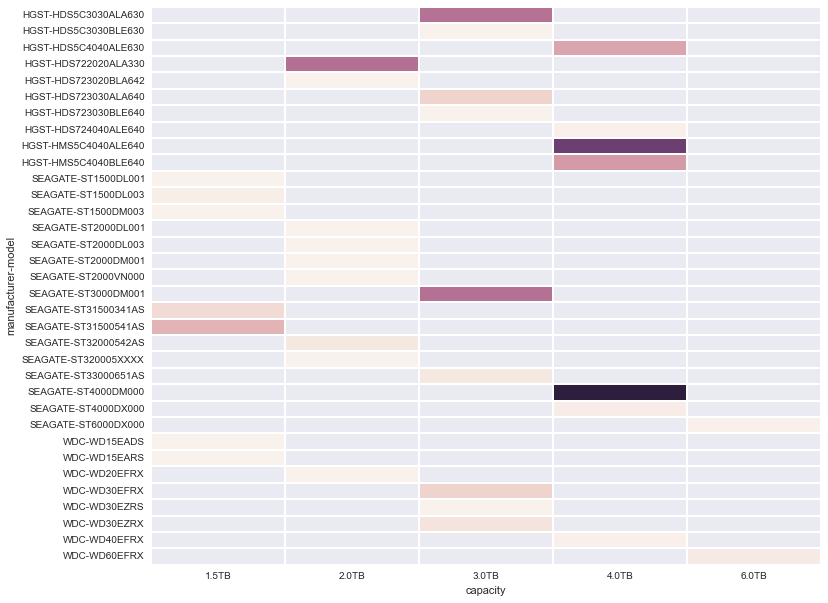

In [66]:
gp = df.groupby(['manufacturer','model','capacity']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=False)

## 6. Checking: are start/end dates are well distributed?

##### Add processed months

**Observe:** there's a huge number of start dates given as '2013-04-10' the start of the study, so assume left-censoring at that date. We may need to correct for this later

In [67]:
df['startdateym'] = df['startdate'].apply(lambda x: x.strftime('%Y%m'))
df['enddateym'] = df['enddate'].apply(lambda x: x.strftime('%Y%m'))

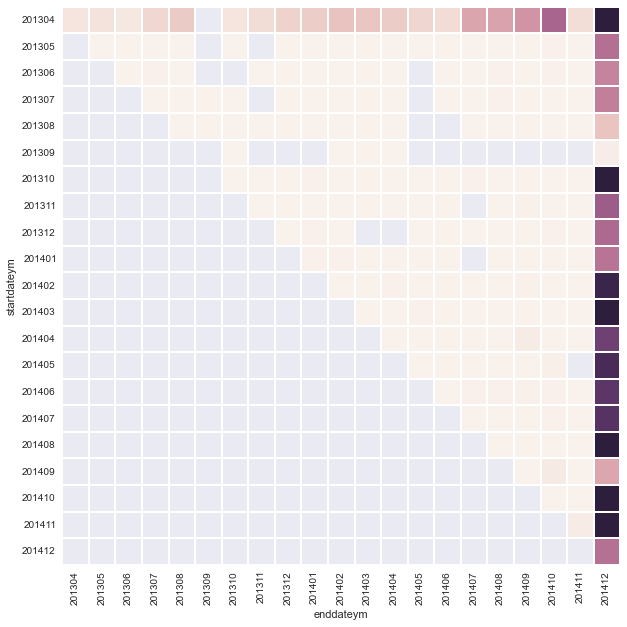

In [68]:
gp = df.groupby(['startdateym','enddateym']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

## 6b. Process startdate enddate into quarters of year

In [69]:
def get_yyyyqq(dt=pd.Timestamp('2000-01-01')):
    return str(dt.year) + str(dt.quarter).zfill(2)

df['startdateyq'] = df['startdate'].apply(get_yyyyqq)
df['enddateyq'] = df['enddate'].apply(get_yyyyqq)

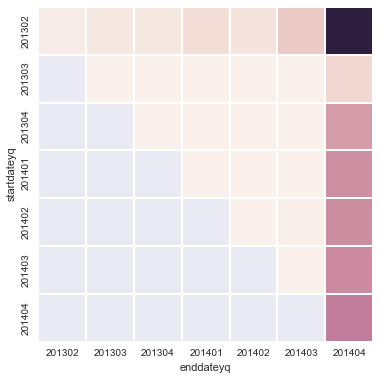

In [70]:
gp = df.groupby(['startdateyq','enddateyq']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=False)

## 7. Checking: Are durations well represented?

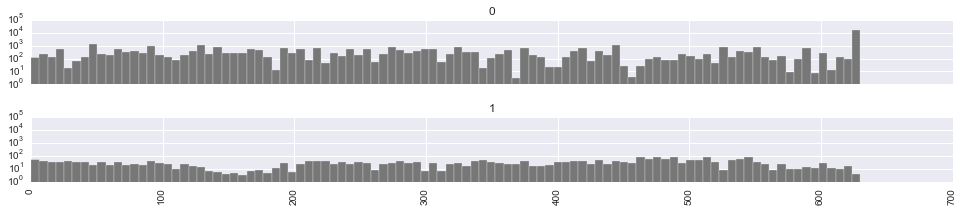

In [71]:
ax=df.hist(column='ndaysduration', by='failed', bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

**Observe:** Failures seem fairly well distributed throughout study, and non-failures are clearly censored around 575 days which is roughly the span April 2013 - Dec 2014: they made it the whole way through.

## 8. Checking are hours of service well distributed?

In [72]:
print(df['nhoursinserviceduringstudy'].describe())
df.loc[df['nhoursinserviceduringstudy'] == 0].shape

count    47252.000000
mean      9418.003111
std       5162.216599
min          0.000000
25%       4681.000000
50%      10008.000000
75%      15109.000000
max      17191.000000
Name: nhoursinserviceduringstudy, dtype: float64


(20, 14)

**Decision:** Remove rows with 0 hours of service

In [73]:
df = df.loc[df['nhoursinserviceduringstudy'] > 0]
df.shape

(47232, 14)

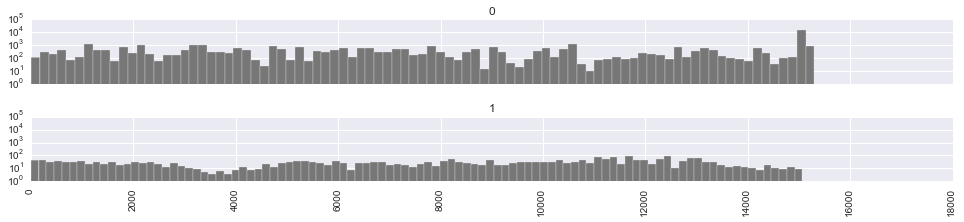

In [74]:
ax=df.hist(column='nhoursinserviceduringstudy', by='failed', bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

**Observe:** Total hours of service seem well distributed, possibly bimodal for those that failed

### Observe hours of service given startdate

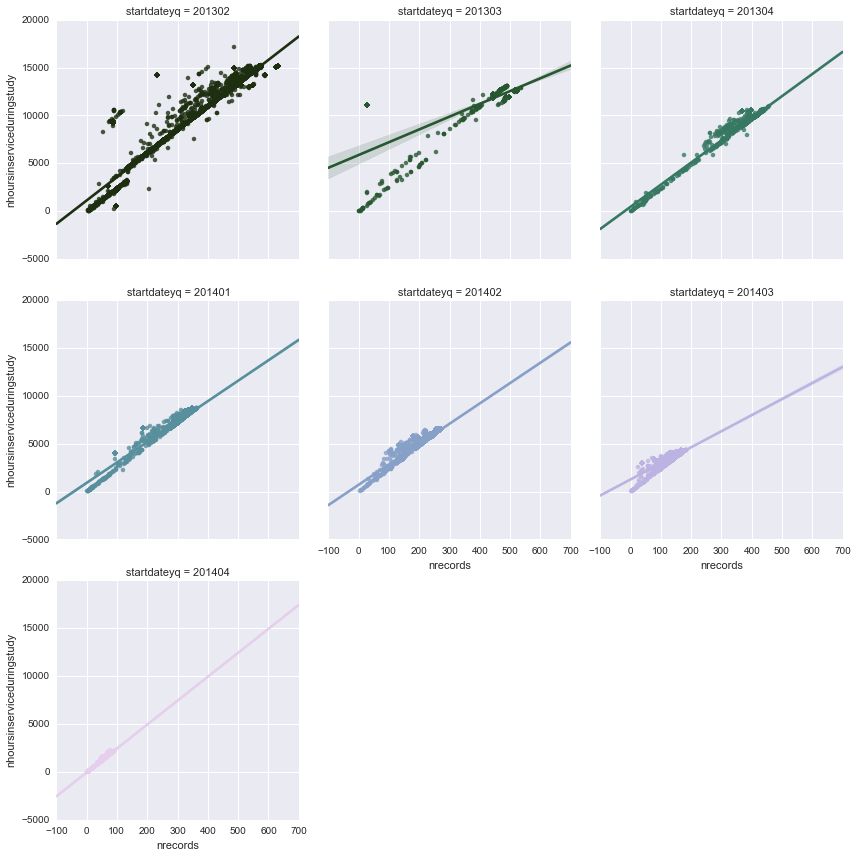

In [75]:
pal = sns.cubehelix_palette(len(np.unique(df['startdateyq'])), 1.4, .75)
ax = sns.lmplot(data=df, x='nrecords', y='nhoursinserviceduringstudy', size=4, col_wrap=3, palette=pal[::-1]
                ,col='startdateyq', hue='startdateyq') #, robust=True, n_boot=500)

**Observe:** regression lines are similar, so seems reasonable to quote an average uptime parameter

---

## Prettify column names

In [76]:
df.rename(columns={'nhoursinserviceduringstudy':'nhoursinservice'}, inplace=True)

## Drop unnecessary columns

In [77]:
del df['capacitybytes']

## Final look

In [78]:
print(df.shape)
df.describe()

(47232, 13)


,nrecords,nhoursinservice,failed,ndaysduration
count,47232.000000,47232.000000,47232.000000,47232.000000
mean,360.939003,9421.991087,0.059494,395.080983
std,194.637474,5159.669473,0.236549,214.942854
min,2.000000,1.000000,0.000000,1.000000
25%,181.000000,4681.000000,0.000000,200.000000
50%,395.000000,10008.000000,0.000000,419.000000
75%,571.000000,15109.000000,0.000000,630.000000
max,630.000000,17191.000000,1.000000,630.000000


## Process mean count of hours per day during service

In [79]:
df['meanhoursperdayservice'] = df['nhoursinservice'] / df['ndaysduration']
df['meanhoursperdayservice'].describe()

count    47232.000000
mean        23.814133
std          1.129119
min          0.166667
25%         23.984127
50%         23.993213
75%         24.003175
max         35.937008
Name: meanhoursperdayservice, dtype: float64

Okay, we tried to limit the mean hours per day to the actual, possible values, but that seems not to have worked.

Whats the outliers at least?

In [80]:
df.loc[df['meanhoursperdayservice'] > 25].shape

(5, 14)

**Solution:** Exclude these rows with impossible hours of service

(NOTE) will allow up to float 25 hours to allow for rounding errors etc

In [81]:
df = df.loc[df['meanhoursperdayservice'] < 25]
df.shape

(47226, 14)

## Write back to DB

In [82]:
df.to_sql('drive_survival_prepared', con=cnx, if_exists='replace', index_label='diskid')

---

---
<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>